In [1]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax
from cnpe.losses import AmortizedMaximumLikelihood, ContrastiveLoss
from cnpe.train import train
from flowjax.distributions import AbstractDistribution, Normal
from flowjax.experimental.numpyro import sample
from flowjax.wrappers import Lambda
from numpyro.infer import Predictive

from cnpe_validation.plot_utils import pairplot_dictionary
from cnpe_validation.utils import MLPParameterizedDistribution


class GaussianModel(eqx.Module):
    dim: int
    prior: AbstractDistribution
    likelihood_std: float

    def __init__(self, dim):
        self.dim = dim
        self.prior = Normal(jnp.zeros(self.dim))
        self.likelihood_std = 0.01

    def __call__(self, obs=None):
        theta = sample("theta", self.prior)
        sample("x", Normal(theta, self.likelihood_std), obs=obs)

class GaussianGuide(eqx.Module):
    theta: AbstractDistribution

    def __init__(self, key, dim):
        # For stability we contrain the minimum scale
        normal = Normal(jnp.zeros(dim), 5*jnp.ones(dim))
        normal = eqx.tree_at(
            lambda normal: normal.bijection.scale,
            normal,
            Lambda(lambda scale: scale + 1e-2, scale=normal.bijection.scale),
        )

        self.theta = MLPParameterizedDistribution(
            key, normal,
            cond_dim=dim,
            width_size=100,
            )

    def __call__(self, obs=None):
        sample("theta", self.theta, condition=obs)

dim = 10
model = GaussianModel(dim)
key, subkey = jr.split(jr.PRNGKey(1))
guide = GaussianGuide(subkey, dim)

key, subkey = jr.split(key)
obs = Predictive(model, num_samples=1)(subkey)
obs = {k: v.squeeze(0) for k, v in obs.items()}

100%|██████████| 2000/2000 [00:10<00:00, 196.83it/s, loss=29]     


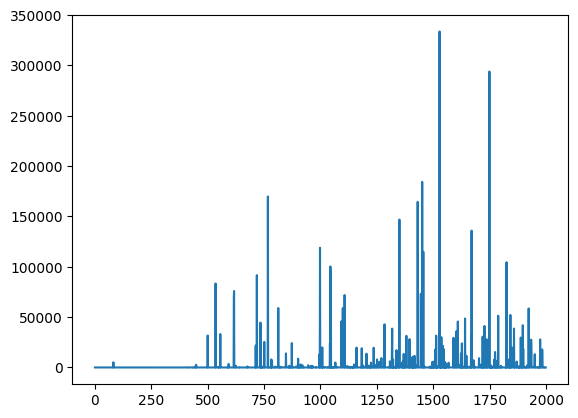

In [8]:

# Pretrain using amortized maximum likelihood
steps=2000

loss = AmortizedMaximumLikelihood(
    model=model,
    obs_name="x",
)

optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
        )

guide_aml, losses = train(
    subkey,
    guide=guide,
    loss_fn=loss,
    steps=steps,
    optimizer=optimizer,
    convergence_window_size=1000,  # Avoid triggering
    
    )

plt.plot(losses)

100%|██████████| 2000/2000 [00:10<00:00, 183.02it/s, loss=-16.9]   


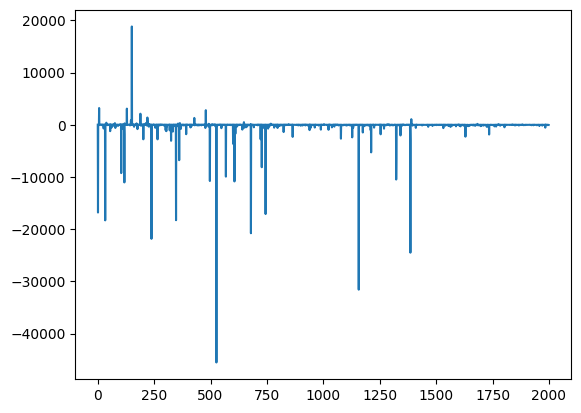

In [9]:
# Train using contrastive
steps=2000

loss = ContrastiveLoss(
    model=model,
    obs_name="x",
    obs=obs["x"],
    n_contrastive=20,
    stop_grad_for_contrastive_sampling=False,
)

optimizer = optax.chain(
        optax.clip_by_global_norm(1),
        optax.adam(1e-4),
)


guide_contrastive, losses = train(
    subkey,
    guide=guide_aml,
    loss_fn=loss,
    steps=steps,
    optimizer=optimizer,
    convergence_window_size=steps,  # Avoid triggering
    )

plt.plot(losses)

In [11]:

def get_true_posterior(prior_mean, prior_std, obs, likelihood_std):
    prior_mean, prior_std, likelihood_std, obs = jnp.broadcast_arrays(
        prior_mean, prior_std, likelihood_std, obs,
        )
    prior_var, likelihood_var = prior_std**2, likelihood_std**2
    var = 1/(1/prior_var + 1/likelihood_var)
    mean = var * ((1/prior_var*prior_mean) + (1/likelihood_var*obs))
    return Normal(mean, var**0.5)

truth = get_true_posterior(
    prior_mean=model.prior.loc,
    prior_std=model.prior.scale,
    obs=obs["x"],
    likelihood_std=model.likelihood_std,
    )
n_samps = 100
limit_dim = 5
pairplot_dictionary(
    {
        "prior": Predictive(model, num_samples=n_samps)(key, obs=obs["x"])["theta"][:, :limit_dim],
        "ML": Predictive(guide_aml, num_samples=n_samps)(key, obs=obs["x"])["theta"][:, :limit_dim],
        "Contrastive": Predictive(guide_contrastive, num_samples=n_samps)(key, obs=obs["x"])["theta"][:, :limit_dim],
        "true": truth.sample(key, (n_samps, ))[:, :limit_dim],
    },
)

# Even on a simple task it fails with enough steps!

In [5]:
# from cnpe_validation.plot_utils import plot_contrastive_aux
# from importlib import reload
# import cnpe_validation
# reload(cnpe_validation.plot_utils)
# from cnpe_validation.plot_utils import plot_contrastive_aux

# plot_contrastive_aux(aux, 0.999)

In [6]:
# # Gradient comparison:
# from functools import partial
# import jax
# from jax.flatten_util import ravel_pytree

# n_contrastive = [5, 50, 100]

# fig, axes = plt.subplots(2)

# n=500

# key = jr.PRNGKey(0)

# for k in n_contrastive:
#     loss_stop_grad, loss_no_stop_grad = (
#         ContrastiveLoss(
#             model=model,
#             obs=obs["x"],
#             obs_name="x",
#             n_contrastive=k,
#             stop_grad_for_contrastive_sampling=stop_grad,
#         ) for stop_grad in (True, False)
#     )

#     losses = {
#         "stop_grad": loss_stop_grad,
#         "no_stop_grad": loss_no_stop_grad,
#     }

#     grads = {}

#     for label, loss in losses.items():

#         params, static = eqx.partition(guide_contrastive, eqx.is_inexact_array)

#         def grad_single(key, params, static, loss):
#             return eqx.filter_jit(eqx.filter_grad(loss))(params, static, key)
        
        
#         grad_single = partial(grad_single, params=params, static=static, loss=loss)

#         keys = jr.split(jr.PRNGKey(0), n)
#         grads[label] = jax.jit(eqx.filter_vmap(grad_single))(keys)


#     stop_grad_grads = eqx.filter_vmap(ravel_pytree)(grads["stop_grad"])[0]
#     no_stop_grad_grads = eqx.filter_vmap(ravel_pytree)(grads["no_stop_grad"])[0]

#     axes[0].scatter(
#         stop_grad_grads.mean(axis=0),
#         no_stop_grad_grads.mean(axis=0),
#         s=3,
#         label=k,
#     )

#     axes[0].set_title(f"Mean gradient for each parameter over {n} samples (each point is a parameter)")
#     axes[0].set_xlabel(r"$\phi$ not in contrastive sampling")
#     axes[0].set_ylabel(r"$\phi$ in contrastive sampling")
#     axes[0].plot([-5, 5], [-5, 5], color="tab:orange")

#     axes[1].scatter(
#         stop_grad_grads.var(axis=0),
#         no_stop_grad_grads.var(axis=0),
#         s=1,
#         label=k,
#     )
#     axes[1].plot([0, 200], [0, 200], color="tab:orange")
#     axes[1].set_title(f"Variance of gradient for each parameter over {n} samples (each point is a parameter)")
#     axes[1].set_xlabel(r"$\phi$ not in contrastive sampling")
#     axes[1].set_ylabel(r"$\phi$ in contrastive sampling")
#     axes[1].set_xlim(0, 50)
#     axes[1].set_ylim(0, 50)

# fig.legend()
# fig.tight_layout()


In [7]:
(no_stop_grad_grads.var(axis=0) < stop_grad_grads.var(axis=0)).mean()
# THis doesn't seem to agree with plot

NameError: name 'no_stop_grad_grads' is not defined